In [1]:
import socket
import struct
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import glob, os

In [2]:
computer_path = '/Users/HHG'
data_path = computer_path + '/FilesRepositories'
plot_path = data_path + '/Project/TemporalFreq/'

tdrDir = '/Users/HHG/FilesRepositories/AEDAT/TempFreq_rfr0_108/'
dataDir = tdrDir
os.chdir(dataDir)

data_n17_list = glob.glob("N17*")
data_n2165_list = glob.glob("N2165*")
data_n2669_list = glob.glob("N2669*")
data_n17_read = []
data_n2165_read = []
data_n2669_read = []

for i in data_n17_list:
    data_n17_read.append(open(i,"rb"))
for i in data_n2165_list:
    data_n2165_read.append(open(i,"rb"))
for i in data_n2669_list:
    data_n2669_read.append(open(i,"rb"))
    debug = False
#print data_n17_read
#print data_n2165_read

In [3]:
def read_events(file):
    """ A simple function that read dynap-se events from cAER aedat 3.0 file format"""
    
    # raise Exception at end of file
    data = file.read(28)
    if(len(data) <= 0):
        print("read all data\n")
        raise NameError('END OF DATA')


    # read header
    eventtype = struct.unpack('H', data[0:2])[0]
    eventsource = struct.unpack('H', data[2:4])[0]
    eventsize = struct.unpack('I', data[4:8])[0]
    eventoffset = struct.unpack('I', data[8:12])[0]
    eventtsoverflow = struct.unpack('I', data[12:16])[0]
    eventcapacity = struct.unpack('I', data[16:20])[0]
    eventnumber = struct.unpack('I', data[20:24])[0]
    eventvalid = struct.unpack('I', data[24:28])[0]
    next_read = eventcapacity * eventsize  # we now read the full packet
    data = file.read(next_read)    
    counter = 0  # eventnumber[0]
    #spike events
    core_id_tot = []
    chip_id_tot = []
    neuron_id_tot = []
    ts_tot =[]
    #special events
    spec_type_tot =[]
    spec_ts_tot = []

    if(eventtype == 0):
        spec_type_tot =[]
        spec_ts_tot = []
        while(data[counter:counter + eventsize]):  # loop over all event packets
            special_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            spec_type = (special_data >> 1) & 0x0000007F
            spec_type_tot.append(spec_type)
            spec_ts_tot.append(timestamp)
            if(spec_type == 6 or spec_type == 7 or spec_type == 9 or spec_type == 10):
                print (timestamp, spec_type)
            counter = counter + eventsize        
    elif(eventtype == 12):
        while(data[counter:counter + eventsize]):  # loop over all event packets
            aer_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            core_id = (aer_data >> 1) & 0x0000001F
            chip_id = (aer_data >> 6) & 0x0000003F
            neuron_id = (aer_data >> 12) & 0x000FFFFF
            core_id_tot.append(core_id)
            chip_id_tot.append(chip_id)
            neuron_id_tot.append(neuron_id)
            ts_tot.append(timestamp)
            counter = counter + eventsize
            if(debug):          
                print("chip id "+str(chip_id)+'\n')
                print("core_id "+str(core_id)+'\n')
                print("neuron_id "+str(neuron_id)+'\n')
                print("timestamp "+str(timestamp)+'\n')
                print("####\n")


    return core_id_tot, chip_id_tot, neuron_id_tot, ts_tot, spec_type_tot, spec_ts_tot

In [4]:
def skip_header(file):
    ''' This function skip the standard header of the recording file '''
    line = file.readline()
    while line.startswith("#"):
        if ( line == '#!END-HEADER\r\n'):
            break
        else:
            line = file.readline()

In [5]:
done_reading_17 = [False,False,False,False,False]
done_reading_2165 = [False,False,False,False,False]
done_reading_2669 = [False,False,False,False,False]

for data in data_n17_read:
    skip_header(data)
for data in data_n2165_read:
    skip_header(data)
for data in data_n2669_read:
    skip_header(data)
    
times_17 = []
times_2165 = []
times_2669 = []
neuron_17 = []
neuron_21 = []
neuron_65 = []
neuron_26 = []
neuron_69 = []

for k in range(3):
    for i in range(len(data_n17_read)):
        chip_id_tot = []
        core_id_tot = []
        neuron_id_tot = []
        ts_tot  = []
        spec_type_tot = []
        spec_ts_tot = []
        
        if (k==0):
            done_reading = done_reading_17
            datareadlist = data_n17_read
        elif (k==1):
            done_reading = done_reading_2165
            datareadlist = data_n2165_read
        elif (k==2):
            done_reading = done_reading_2669
            datareadlist = data_n2669_read
        while(done_reading[i] == False):
            try:
                core_id, chip_id, neuron_id, ts, spec_type, spec_ts = read_events(datareadlist[i])
                core_id_tot.extend(np.array(core_id))
                chip_id_tot.extend(np.array(chip_id))
                neuron_id_tot.extend(np.array(neuron_id))
                ts_tot.extend(np.array(ts))
                spec_type_tot.extend(np.array(spec_type))
                spec_ts_tot.extend(np.array(spec_ts))
                    
            except NameError:
                datareadlist[i].close()
                done_reading[i] = True
        neuron_id_d = []
        ts_id_d = []
        for chip, core, neur, ts in zip(chip_id_tot, core_id_tot, neuron_id_tot, ts_tot):
            if chip == 1 and core == 2:
                neuron_id_d.append(neur)
                ts_id_d.append(ts)
        if (k==0):
            times_17.append(ts_tot[-1]-ts_tot[0])
            neuron_17.append(neuron_id_d.count(17))
        if (k==1):
            times_2165.append(ts_tot[-1]-ts_tot[0])
            neuron_21.append(neuron_id_d.count(21))
            neuron_65.append(neuron_id_d.count(65))
        if (k==2):
            times_2669.append(ts_tot[-1]-ts_tot[0])
            neuron_26.append(neuron_id_d.count(26))
            neuron_69.append(neuron_id_d.count(69))        

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data



In [6]:
activity_17 = []
activity_21 = []
activity_65 = []
activity_26 = []
activity_69 = []

times_17sec = [i * (10**-6) for i in times_17]
times_2165sec = [i * (10**-6) for i in times_2165]
times_2669sec = [i * (10**-6) for i in times_2669]

for i,count in enumerate(neuron_17):
    activity_17.append(count/times_17sec[i])
print activity_17
for i,count in enumerate(neuron_21):
    activity_21.append(count/times_2165sec[i])
print activity_21
for i,count in enumerate(neuron_65):
    activity_65.append(count/times_2165sec[i])
print activity_65
for i,count in enumerate(neuron_26):
    activity_26.append(count/times_2669sec[i])
print activity_26
for i,count in enumerate(neuron_69):
    activity_69.append(count/times_2669sec[i])
print activity_69

[4.0125926171285622, 11.40273041094626, 14.103935613094899, 15.741494912843171, 15.816023294370408]
[3.3333540405326758, 4.6057832087508013, 5.2561934964720338, 5.8092020444071117, 5.6774261170335887]
[9.8485460288465418, 14.285734359345705, 16.69614404761705, 18.703994188048814, 18.75932755453406]
[5.3333982230117138, 8.7151032739737957, 11.225231253453128, 12.899894452335372, 13.045585931781861]
[5.3333982230117138, 10.391084672814911, 12.867948022251147, 14.902499034653566, 15.300378561966381]


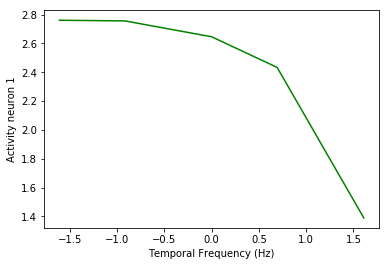

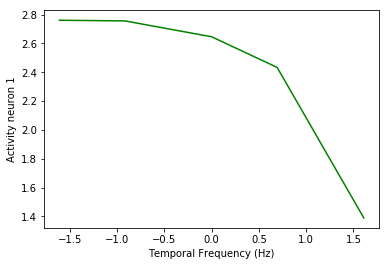

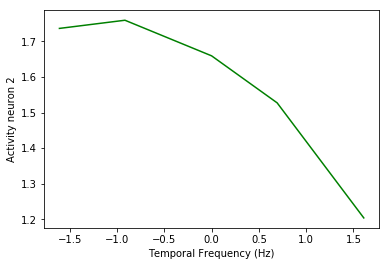

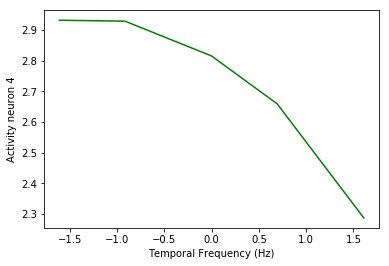

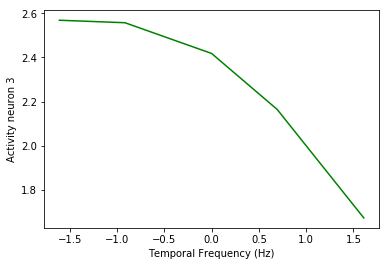

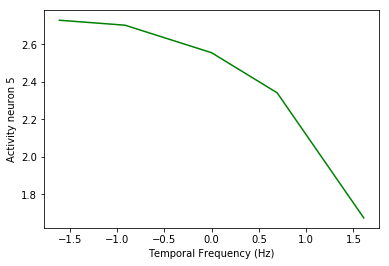

In [8]:
freq = [5,2,1,0.4,0.2]
plt.clf()
fig1 = plt.figure()
plt.plot(np.log(freq), np.log(activity_17), 'g-')
plt.ylabel('Activity neuron 1') #17   
plt.xlabel('Temporal Frequency (Hz)')
fig1.savefig(plot_path + 'Activity17vsTempfreq', format='png', dpi=200)

fig2 = plt.figure()
plt.plot(np.log(freq), np.log(activity_21), 'g-')
plt.ylabel('Activity neuron 2')#21    
plt.xlabel('Temporal Frequency (Hz)')
fig2.savefig(plot_path + 'Activity21vsTempfreq', format='png', dpi=200)

fig3 = plt.figure()
plt.plot(np.log(freq), np.log(activity_65), 'g-')
plt.ylabel('Activity neuron 4')#65  
plt.xlabel('Temporal Frequency (Hz)')
fig3.savefig(plot_path + 'Activity65vsTempfreq', format='png', dpi=200)

fig4 = plt.figure()
plt.plot(np.log(freq), np.log(activity_26), 'g-')
plt.ylabel('Activity neuron 3')#26    
plt.xlabel('Temporal Frequency (Hz)')
fig4.savefig(plot_path + 'Activity26vsTempfreq', format='png', dpi=200)

fig5 = plt.figure()
plt.plot(np.log(freq), np.log(activity_69), 'g-')
plt.ylabel('Activity neuron 5')#69   
plt.xlabel('Temporal Frequency (Hz)')
fig5.savefig(plot_path + 'Activity69vsTempfreq', format='png', dpi=200)

plt.show()